<a href="https://colab.research.google.com/github/aditeyabaral/abstractive-summarization/blob/main/src/Summarize%20Headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [3]:
!curl -L -O https://raw.githubusercontent.com/aditeyabaral/abstractive-summarization/main/data/news_summary_more.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.4M  100 39.4M    0     0   206M      0 --:--:-- --:--:-- --:--:--  206M


In [4]:
!curl -L -O https://raw.githubusercontent.com/aditeyabaral/abstractive-summarization/main/src/attention.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5230  100  5230    0     0   283k      0 --:--:-- --:--:-- --:--:--  283k


In [5]:
import numpy as np
import pandas as pd
import re
import string
from google.colab import files
from gensim.models import FastText
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import attention
from attention import AttentionLayer

2021-01-15 04:53:04,454 : INFO : 'pattern' package not found; tag filters are not available for English


# Reading Dataset

In [6]:
df = pd.read_csv("news_summary_more.csv")
# df.drop(columns=["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(98401, 2)


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# Preprocessing Data

In [7]:
def formatArticleHeader(text):
  text = text.strip().split("\n\n")
  header = text[0] + ". "
  del text[0]
  #text[0] = header + text[0]
  text = "\n\n".join(text)
  return text

In [8]:
def cleanText(text):
  contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
  # text = text.lower()
  text = re.sub(" +", " ", text)
  text = re.sub("\n+", " ", text)
  text = " ".join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split()])
  return text

  # more preprocessing
  text = re.sub("[^a-zA-Z0-9\n]", " ", text)
  text = re.sub(r'\([^)]*\)', '', text)
  text = re.sub('"','', text)
  text = re.sub(r"'s\b","",text)
  return text 

In [9]:
# df["text"] = df["text"].apply(lambda x: formatArticleHeader(x))
df["text"] = df["text"].apply(lambda x: cleanText(x))
df["headlines"] = df["headlines"].apply(lambda x: "starttoken " + cleanText(x) + " endtoken")

In [10]:
df.head()

,headlines,text
0,starttoken upGrad learner switches to career i...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,starttoken Delhi techie wins free food from Sw...,Kunal Shah's credit card bill payment platform...
2,starttoken New Zealand end Rohit Sharma-led In...,New Zealand defeated India by 8 wickets in the...
3,starttoken Aegon life iTerm insurance plan hel...,"With Aegon Life iTerm Insurance plan, customer..."
4,"starttoken Have known Hirani for yrs, what if ...",Speaking about the sexual harassment allegatio...


# Training fastText

In [11]:
X_words = list(map(word_tokenize, df["text"].values))
y_words = list(map(word_tokenize, df["headlines"].values))

In [12]:
"""ft_model = FastText(min_count=1)
ft_model.build_vocab(sentences=X_words+y_words)
ft_model.train(sentences=X_words+y_words, total_examples=ft_model.corpus_count, epochs=10)"""

'ft_model = FastText(min_count=1)\nft_model.build_vocab(sentences=X_words+y_words)\nft_model.train(sentences=X_words+y_words, total_examples=ft_model.corpus_count, epochs=10)'

In [13]:
#word2embedding = {word:ft_model.wv.get_vector(word) for word in list(ft_model.wv.vocab)}

# Finding Sequence Parameters

In [14]:
X_text = df["text"].values
y_text = df["headlines"].values

In [15]:
Tx = len(max(X_words, key=len))
Ty = len(max(y_words, key=len))
print(f"Tx = {Tx}\nTy = {Ty}")

Tx = 98
Ty = 22


In [16]:
tokenizer_X = Tokenizer()
tokenizer_X.fit_on_texts(list(X_text))
X_seq = tokenizer_X.texts_to_sequences(X_text)
X_seq = pad_sequences(X_seq,  maxlen=Tx, padding='post') 
vocab_size_X = len(tokenizer_X.word_index) + 1 

tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(list(y_text))
y_seq = tokenizer_y.texts_to_sequences(y_text)
y_seq = pad_sequences(y_seq,  maxlen=Ty, padding='post') 
vocab_size_y = len(tokenizer_y.word_index) + 1 

print(f"Vocabulary Size of X = {vocab_size_X}\nVocabulary Size of y = {vocab_size_y}")

Vocabulary Size of X = 101008
Vocabulary Size of y = 44826


In [17]:
X_seq.shape, y_seq.shape

((98401, 98), (98401, 22))

# Creating Sequences

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.05, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((93480, 98), (4921, 98), (93480, 22), (4921, 22))

# Building Model

In [19]:
dim=512

#encoder
encoder_input = Input(shape=(Tx, ))
  
enc_embedding =  Embedding(vocab_size_X, 100, trainable=True)(encoder_input)

encoder_LSTM_1 = LSTM(dim, return_state=True, return_sequences=True)
encoder_out_1, hidden_state_1, cell_state_1 = encoder_LSTM_1(enc_embedding)

encoder_LSTM_2 = LSTM(dim, return_state=True, return_sequences=True)
encoder_out_2, hidden_state_2, cell_state_2 = encoder_LSTM_2(encoder_out_1)

encoder_LSTM_3 = LSTM(dim, return_state=True, return_sequences=True)
encoder_out_3, hidden_state_3, cell_state_3 = encoder_LSTM_3(encoder_out_2)

encoder_states = [hidden_state_3, cell_state_3]

#decoder
decoder_input = Input(shape=(None, ))
  
dec_emb_layer = Embedding(vocab_size_y, 100, trainable=True)
dec_emb = dec_emb_layer(decoder_input)

decoder_LSTM_1 = LSTM(dim, return_state=True, return_sequences=True)
decoder_out_1, decoder_fwd_state, decoder_back_state = decoder_LSTM_1(dec_emb, initial_state=encoder_states)

#decoder_LSTM_2 = LSTM(64, return_state=True)
#decoder_out_2, decoder_fwd_state, decoder_back_state = decoder_LSTM_2(decoder_out_1)

attention_layer = AttentionLayer()
attention_output, attention_states = attention_layer([encoder_out_3, decoder_out_1])

decoder_concat = Concatenate(axis=-1)([decoder_out_1, attention_output])

decoder_dense = TimeDistributed(Dense(vocab_size_y, activation='softmax'))
decoder_output = decoder_dense(decoder_concat)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

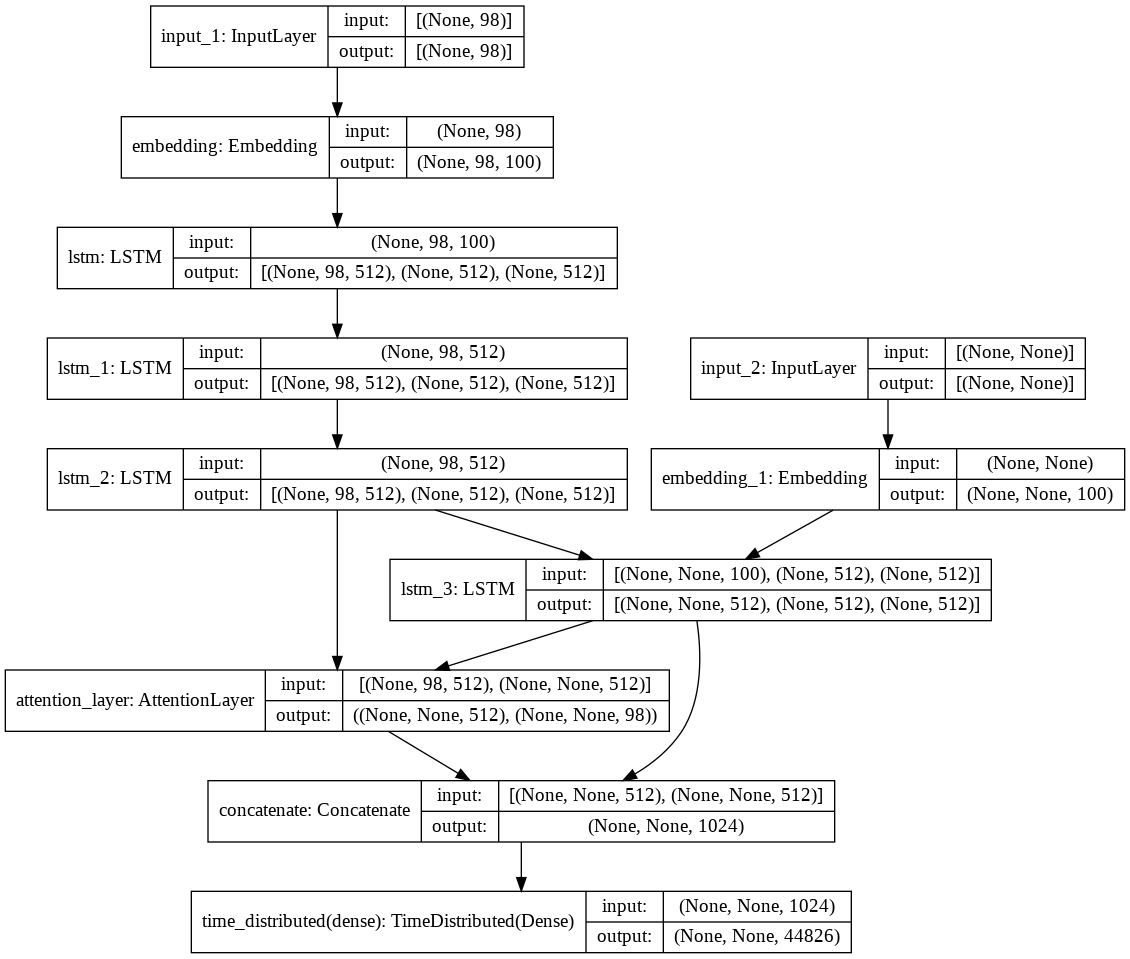

In [20]:
plot_model(model, show_shapes=True)

In [21]:
history = model.fit(
    [X_train,y_train[:,:-1]], 
    y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],
    epochs=10,
    batch_size=128, 
    validation_data=([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:])
    )

Epoch 1/10
731/731 [==============================] - 596s 804ms/step - loss: 4.2806 - accuracy: 0.5252 - val_loss: 3.5200 - val_accuracy: 0.5554
Epoch 2/10
731/731 [==============================] - 594s 813ms/step - loss: 3.3041 - accuracy: 0.5640 - val_loss: 3.0544 - val_accuracy: 0.5797
Epoch 3/10
731/731 [==============================] - 597s 816ms/step - loss: 2.7604 - accuracy: 0.5913 - val_loss: 2.7782 - val_accuracy: 0.6009
Epoch 4/10
731/731 [==============================] - 597s 816ms/step - loss: 2.3217 - accuracy: 0.6192 - val_loss: 2.6259 - val_accuracy: 0.6151
Epoch 5/10
731/731 [==============================] - 597s 817ms/step - loss: 1.9356 - accuracy: 0.6525 - val_loss: 2.5649 - val_accuracy: 0.6218
Epoch 6/10
731/731 [==============================] - 598s 818ms/step - loss: 1.6210 - accuracy: 0.6903 - val_loss: 2.5501 - val_accuracy: 0.6272
Epoch 7/10
731/731 [==============================] - 597s 817ms/step - loss: 1.3758 - accuracy: 0.7246 - val_loss: 2.5617 -

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
reverse_target_word_index = tokenizer_y.index_word
reverse_source_word_index = tokenizer_X.index_word
target_word_index = tokenizer_y.word_index

In [23]:
 # Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_input, outputs=[encoder_out_3, hidden_state_3, cell_state_3])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(dim,))
decoder_state_input_c = Input(shape=(dim,))
decoder_hidden_state_input = Input(shape=(Tx, dim))

In [24]:
dec_emb2 = dec_emb_layer(decoder_input) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_LSTM_1(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_input] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [25]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['starttoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (Ty-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [26]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starttoken']) and i!=target_word_index['endtoken']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [27]:
for i in range(100):
    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1, Tx)))
    print("\n")

Review: army jawan rajendra singh lost his life when a group of youths hurled stones at an army vehicle in jammu and kashmir an army official informed on friday the 22 year old jawan was part of a quick reaction team providing security to a border roads organisation convoy and was attacked when the convoy was passing through anantnag bypass tri junction 
Original summary: 22 yr old jawan dies after being hit by stones thrown by youths 
Predicted summary:  jawan who was shot by stones thrown from army camp in j k


Review: ibrahim shaik a 28 year old plumber working on the sets of the tamil version of the reality show 'bigg boss' died of a seizure after he collapsed while at work shaik was given emergency medical aid before being taken to chennai's kilpauk medical college hospital where he was declared brought dead the local police have registered a case regarding the incident 
Original summary: worker dies on sets of tamil version of 'bigg boss' 
Predicted summary:  bigg boss 11 contes

In [ ]:
encoder_model.save("headlines_model_encoder.h5")
files.download("headlines_model_encoder.h5")

encoder_model.save("headlines_model_decoder.h5")
files.download("headlines_model_decoder.h5")